### SAKI Exercise 1 - Paul Kremer
Imports

In [22]:
import copy

import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns

Read dataset

In [23]:
# file_name = "SAKI Exercise 1 - Transaction Classification - Data Set.csv"
file_name = "data.csv"
data_csv = pd.read_csv(file_name, sep=";")
print("Describe Data Set")
print(data_csv.shape)
data_csv.describe(include = object)

Describe Data Set
(209, 12)


,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
count,209,209,209,209,209,208,208,209,209,209
unique,85,85,14,125,59,53,40,94,1,6
top,15.03.2016,02.02.2016,Lastschrift (Einzugsermächtigung),Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,922904916,25190001,2000.00,EUR,leisure
freq,8,8,94,13,17,34,49,13,209,65


Preprocessing


In [24]:
discrete_columns = ['Buchungstag', 'Valutadatum', 'Buchungstext', 'Beguenstigter/Zahlungspflichtiger', 'Kontonummer', 'BLZ']
purpose_column = 'Verwendungszweck'
amount_column = 'Betrag' #"Betrag" is the only continuous column
label_column = 'label'

#one hot encode all discrete columns
one_hot_encoded_features = pd.get_dummies(data_csv[discrete_columns])

# create frequency array for "Verwendungszweck"
count_vector = CountVectorizer()
count_vector.fit(data_csv[purpose_column])
purpose_data = count_vector.transform(data_csv[purpose_column]).toarray()
purpose_data = MinMaxScaler().fit_transform(purpose_data)

#scale "Betrag" column to values between 0 and 1
amount_data = data_csv.iloc[:,data_csv.columns.get_loc(amount_column)]
amount_data = amount_data.str.replace(',','.').astype(float).values #floating point values should be separated with "." instead of ","
amount_data = MinMaxScaler().fit_transform(amount_data.reshape(-1,1))

# saving the labels as list to label the confusion matrix later
label_list = sorted(set(data_csv[label_column]))
label_dict = dict([(label, id) for id, label in enumerate(label_list)])
labels = [label_dict[id] for id in data_csv[label_column]]

# construct feature DataFrame
features = pd.DataFrame(np.hstack((one_hot_encoded_features, purpose_data, amount_data)))
features.head()


,0,1,2,3,4,5,6,7,8,9,...,666,667,668,669,670,671,672,673,674,675
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.876508
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.542183
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.617312
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.616910
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.580624


Train the GNB Classifier

In [25]:
gnb = GaussianNB()
scores = cross_val_score(gnb, features, labels, cv=6)
print("Accuracy for each batch:")
print(scores)
print("Average Accuracy:")
print(scores.mean())
pred_labels = cross_val_predict(gnb, features, labels, cv=6)


Accuracy for each batch:
[1.         0.91428571 0.88571429 0.77142857 0.97142857 1.        ]
Average Accuracy:
0.9238095238095237


Plot Confusion Matrix

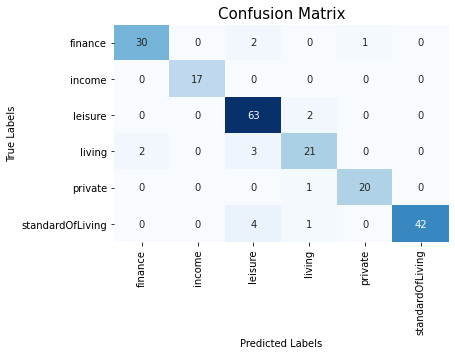

In [26]:
cf_matrix = confusion_matrix(y_true= labels, y_pred=pred_labels)
ax = plt.axes()
cf_matrix = sns.heatmap(cf_matrix
            , annot=True
            , cmap='Blues'
            , cbar=False
            , xticklabels=label_list
            , yticklabels=label_list
            , ax= ax
            )
ax.set_title("Confusion Matrix", fontsize=15)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
plt.savefig("cf_matrix.png", pad_inches=0.3, bbox_inches='tight')
plt.show()

Plot Precision Confusion Matrix

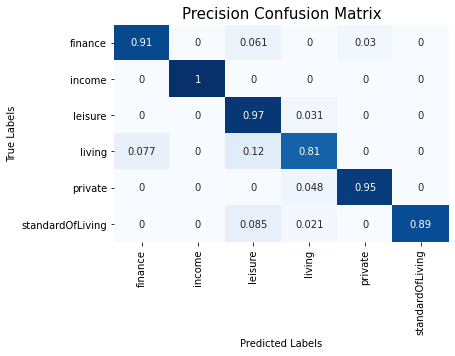

In [27]:
cf_matrix_preci = confusion_matrix(y_true= labels, y_pred=pred_labels, normalize='true')
preci_ax = plt.axes()
sns.heatmap(cf_matrix_preci
            , annot=True
            , cmap='Blues'
            , cbar=False
            , xticklabels=label_list
            , yticklabels=label_list
            , ax= preci_ax
            )
preci_ax.set_title("Precision Confusion Matrix", fontsize=15)
preci_ax.set_xlabel("Predicted Labels")
preci_ax.set_ylabel("True Labels")
plt.savefig("precision.png", pad_inches=0.3, bbox_inches='tight')
plt.show()


Plot Recall Confusion Matrix

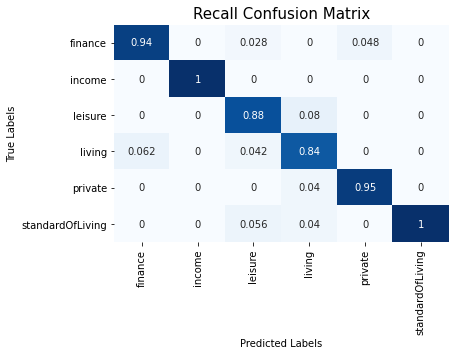

In [28]:
cf_matrix_recall = confusion_matrix(y_true= labels, y_pred=pred_labels, normalize='pred')
recall_ax = plt.axes()
cf_matrix_recall = sns.heatmap(cf_matrix_recall
            , annot=True
            , cmap='Blues'
            , cbar=False
            , xticklabels=label_list
            , yticklabels=label_list
            , ax= recall_ax
            )
recall_ax.set_title("Recall Confusion Matrix", fontsize=15)
recall_ax.set_xlabel("Predicted Labels")
recall_ax.set_ylabel("True Labels")
plt.savefig("recall.png", pad_inches=0.3, bbox_inches='tight')
plt.show()

